# Import all Modules

In [1]:
from ultralytics import YOLO

import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'ultralytics'

# Check if Cuda is Available

In [118]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 0


# Setting up the dataset paths

In [119]:
dataset_path = 'archive'

In [120]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)
    
    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

# Example usage
#print(the_number_in_the_string("file123.txt"))  # Output: 123
#print(the_number_in_the_string("no_numbers_here"))  # Output: 0

# Formatting the XML File and creating DF

In [4]:
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

In [5]:
# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

NameError: name 'glob' is not defined

In [ ]:
# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()
    
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,archive\images\Cars0.png,226,419,125,173,500,268
1,archive\images\Cars1.png,134,262,128,160,400,248
2,archive\images\Cars2.png,229,270,176,193,400,400
3,archive\images\Cars3.png,142,261,128,157,400,225
4,archive\images\Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,archive\images\Cars428.png,142,258,128,157,400,225
429,archive\images\Cars429.png,86,208,166,195,301,400
430,archive\images\Cars430.png,38,116,159,197,400,225
431,archive\images\Cars431.png,55,343,82,147,400,192


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [ ]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [ ]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [ ]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets\cars_license_plate_new\train\images' and 'datasets\cars_license_plate_new\train\labels'
Created 'datasets\cars_license_plate_new\val\images' and 'datasets\cars_license_plate_new\val\labels'
Created 'datasets\cars_license_plate_new\test\images' and 'datasets\cars_license_plate_new\test\labels'


In [ ]:
###############---------------------------------------------------

In [ ]:
# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

In [ ]:
# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

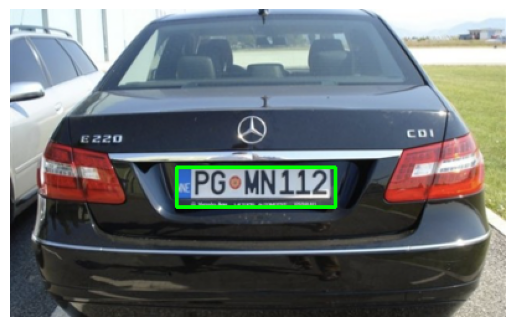

In [ ]:
# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

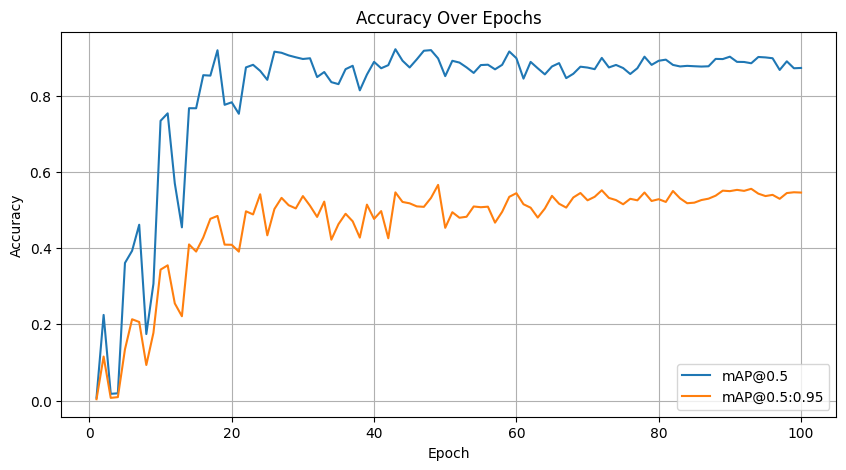

In [ ]:
# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key = the_number_in_the_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model
model = YOLO("runs/detect/train/weights/best.pt")

In [ ]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 c:\Users\user\Desktop\AI\final\archive\images\Cars425.png: 320x640 1 car, 1 truck, 63.6ms
Speed: 1.0ms preprocess, 63.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


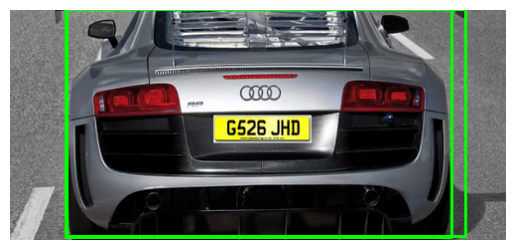

In [ ]:

predict_and_plot(test.iloc[0].img_path)


image 1/1 c:\Users\user\Desktop\AI\final\archive\images\Cars75.png: 416x640 5 persons, 20 cars, 3 buss, 1 truck, 132.2ms
Speed: 2.0ms preprocess, 132.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


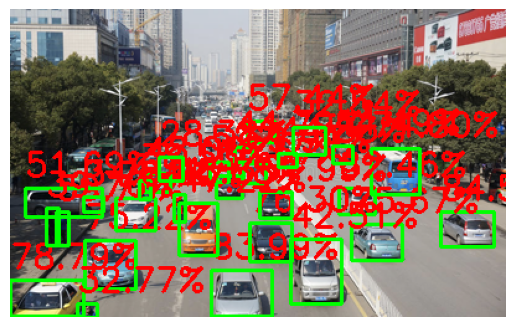

In [ ]:

predict_and_plot(test.iloc[1].img_path)


image 1/1 c:\Users\user\Desktop\AI\final\archive\images\Cars181.png: 640x384 1 car, 48.7ms
Speed: 1.0ms preprocess, 48.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


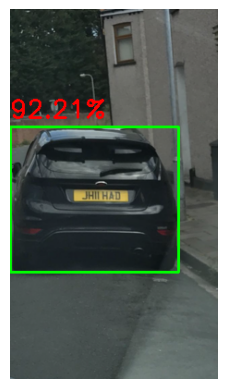

In [ ]:
predict_and_plot(test.iloc[2].img_path)

In [ ]:
import pytesseract
from pytesseract import Output

In [ ]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.
    
    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image

In [ ]:
predict_and_plot(test.iloc[10].img_path)

NameError: name 'predict_and_plot' is not defined

In [ ]:
predict_and_plot(test.iloc[2].img_path)


image 1/1 c:\Users\user\Desktop\AI\final\archive\images\Cars181.png: 640x384 1 car, 51.1ms
Speed: 2.0ms preprocess, 51.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.